# Cvičení 3: Optimalizace, metoda nejměnších čtverců a rozpoznávání not

V tomto cvičení si ukážeme malou ukázku optimalizačních úloh. Ukážeme si metodu nejmenších čtverců a její využití při rozpoznávání not.

---


Toto jsou knihovny a funkcionality, které budeme využívat:


In [ ]:
from scipy import signal as sgn  # pro okenní Fourierovu transformaci
from scipy.io import wavfile  # pro čtení WAV souborů
from IPython.display import Audio  # pro přehrávání zvuků
import numpy as np  # lineární algebra
import matplotlib.pyplot as plt  # vykreslování grafů
from scipy.optimize import minimize  # numerická minimalizace funkce

## Část 1: Motivační Slovní Úloha: Optimalizace Cen a Výrobních Nákladů Limonády

Vlastníte stánek s limonádou a chcete optimalizovat cenu za sklenici, aby se maximalizoval váš zisk. Na základě vašich zkušeností jste zjistili, že počet prodaných limonád $ q $ v závislosti na ceně $ p $ (v korunách) lze aproximovat takto:
$$ q(p) = 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) $$

`Jedná se samozřejmě o spojitou aproximaci, v skutečnosti prodáváte celočíselný počet limonád, ale to v tuhle chvíli nebudeme řešit.`


In [ ]:
p = np.linspace(0, 20, 200)
q = 1000 * np.exp(-(p / 10)**2)

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(p, q)
plt.xlabel('p = Cena za sklenici (Kč)')
plt.ylabel('q = Prodané množství')
plt.title('Prodané množství limonády v závislosti na ceně')
plt.grid(True)
plt.show()

Výrobní náklady na jednu sklenici limonády $ c $ závisí na množství vyrobeného množství $ q $ a jsou dány vztahem:
$$ c(q) = 5 + 15 \exp\left(-\frac{q}{200}\right) $$


In [ ]:
q = np.arange(0, 1000)
c = 5 + 15 * np.exp(-q / 200)

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(q, c)
plt.xlabel('q = Prodané množství')
plt.ylabel('c = Náklady za sklenici (Kč)')
plt.title('Náklady na výrobu limonády v závislosti na prodeji')
plt.grid(True)
plt.show()

**`Cílem je nalézt optimální cenu za sklenici limonády tak, aby se maximalizoval celkový zisk.`**

#### Formulace Optimalizačního Problému

Zisk za sklenici $ z $ je rozdíl mezi cenou a výrobními náklady, tedy:
$$ z = p - c $$

tedy:
$$ z(p) = p - c(q(p)) $$

Celkový zisk $ t $ z prodeje limonády je součin zisku za sklenici a množství prodaných sklenic. Zde je třeba poznamenat, že předpokládáme, že všechny sklenice které vyrobíme, také prodáme, tedy:
$$ t(p) = z(p) q(p) $$

Dáme-li tyto vztahy dohromady, dostaneme:

$$ t(p) = \left( p - 5 - 15 \exp\left(-\frac{ 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) }{200}\right) \right) \left( 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) \right) $$

#### Řešení

Problém spočívá v nalezení hodnoty $ p $, která maximalizuje $ t $.

$$p^* = \argmax_{p \in \mathbb{R}} ~t(p)$$

Toto může vyžadovat použití numerických metod, maximalizovaná funkce je poměrně složitá.


**Zde se jedná o jednodimenzionální optimalizační problém, u kterého navíc víme, že řešení bude někde v intervalu $ [5, 20] $. Proto můžeme zkusit "vyřešit" vizuálně.**


### Úkol 1: Vykreslete funkci $ t(p) $ v intervalu $ [5, 20] $.

In [ ]:
p = np.linspace(5, 20, 1000)
q = 1000 * np.exp(-(p / 10)**2)
c = 5 + 15 * np.exp(-q / 200)
z = p - c
t = z * q

In [ ]:
plt.plot(p, t)
plt.xlabel('Cena za sklenici (Kč)')
plt.ylabel('Celkový zisk')
plt.title('Zisková funkce v závislosti na ceně limonády')
plt.grid(True)
plt.show()

Pro numerické řešení můžeme použít knihovnu `scipy.optimize` a její funkci `minimize`. Tato funkce umí minimalizovat funkce s jednou nebo více proměnnými. V našem případě je třeba funkci maximalizovat, proto je třeba ji předat jako funkci, která vrací opačnou hodnotu.

Funkce `minimize` má mnoho parametrů, a má implementováno mnoho numerických metod pro minimalizaci. My použijeme její výchozí nastavení, typ metody tedy nebude specifikován. Parametry, které musíme specifikovat jsou:

- `fun`: funkce, kterou chceme minimalizovat, musí to být funkce s jedním vstupem (může být vektor) a jedním výstupem (musí být skalár=číslo)
- `x0`: počáteční bod, ze kterého se bude hledat minimum (musí být možné předat funkci `fun`)


### Úkol 2: Nalezněte optimální cenu za sklenici limonády.
- napište funkci `zisk(p)`, která vrací celkový ziskpro cenu `p` za sklenici
- použijte funkci `minimize` pro nalezení optimální ceny
    - jako `fun` použijte funkci `zisk`
    - jako `x0` použijte nějakou hodnotu z intervalu $ [5, 20] $

In [ ]:
def zisk(p):
    q = 1000 * np.exp(-(p / 10)**2)
    c = 5 + 15 * np.exp(-q / 200)
    z = p - c
    t = z * q
    return -t  # minus protože minimize umí hledat minimum


spektra_not = minimize(fun=zisk, x0=10)
spektra_not

Sedí váš výsledek s grafem funkce $ t(p) $?

## Část 2: Metoda nejmenších čtverců a určování zahraných not


### Získání amplitudových spekter not

- ve složce `notes` jsou uloženy zvukové soubory jednotlivých not jak jdou po klapkách na klavíru: `t1.wav`, ..., `t88.wav`
- postupně všechny načteme, znormalizujeme signál a vypočteme amplitudové spektrum pro prvni $\frac{1}{4}$ sekundy nahrávky
  - abychom nemuseli upravovat výsledná spektra, zvolíme stejnou délku signálu/okna pro všechny nahrávky a také následnou náhravku a její okenní Fourierovu transformaci

**Toto prolétneme velmi rychle, neboť jsme si vše již ukázali v minulém cvičení.**

In [ ]:
spektra_not = []
trvani = 1/4

for j in range(1, 89):
    cesta_k_souboru = f"notes/t{j}.wav"  # cesta k souboru
    vzorkovaci_frekvence, signal = wavfile.read(cesta_k_souboru)

    velikost_okna = int(trvani * vzorkovaci_frekvence)
    signal = signal / np.max(np.abs(signal))  # normalizace signálu na [-1, 1]
    signal = signal[:velikost_okna]  # vyřízneme signál ze začátku

    normalizace = 1 / vzorkovaci_frekvence  # normalizace na integrál

    amplitudove_spektrum = np.abs(np.fft.rfft(signal) * 2 * normalizace / trvani)

    spektra_not.append(amplitudove_spektrum)

spektogram_not = np.vstack(spektra_not).T  # převedeme na matici a transponujeme = checme noty ve sloupcích

Zobrazíme výsledná amplitudová spektra not:


In [ ]:
x_axis = np.arange(1, 89)  # x-ová osa = noty
y_axis = np.fft.rfftfreq(n=velikost_okna, d=1 / vzorkovaci_frekvence)  # y-ová osa = frekvence

plt.figure(figsize=(10, 5))
plt.pcolormesh(x_axis, y_axis, spektogram_not, cmap='jet')
plt.xlabel('Nota')
plt.ylabel('Frekvence [Hz]')
plt.ylim(0, 4400)  # ořízneme vyšší frekvence
plt.colorbar()
plt.show()

**Proč to vypadá takto škaredě?**

- jednotlivé noty nemají celočíselné frekvence (což je to co počítáme)
- základní frekvence not klavíru se dají zapsat jako: $$ f_n = 440 \cdot 2^{\frac{n-49}{12}} $$
- tedy pěkné ostrý (nerozmazaný) spektrogram, získáme pouze pro některé noty, jiné budou mít amplitudové spektrum rozostřené


#### Mapování z tónů na na amplitudová spektra

- označíme si matici $A$ jako matici která bude tóny mapovat na amplitudová spektra
- tedy budu-li mít vektor $x$ o délce 88, kde na pozici $i$ bude 1, pak $Ax$ bude amplitudové spektrum noty $i$


**Jak vypadá spektrgram akordu C major?**

In [ ]:
A = spektogram_not

x = np.zeros(88)
x[39] = 1  # C4
x[43] = 1  # E4
x[47] = 1  # G4

spektrum_Cmajor = A @ x

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, spektrum_Cmajor)  # jakožto osu x použijeme frekvence
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

### Načteme vzorovou nahrávku pro určení not a spočítáme její amplitudové spektrum (časově frekvenční spektrogram)


In [ ]:
vzorkovaci_frekvence, signal = wavfile.read('lune1.wav')
signal = signal / np.max(np.abs(signal))

In [ ]:
Audio(signal, rate=vzorkovaci_frekvence)

In [ ]:
delka_nahravky = len(signal) / vzorkovaci_frekvence
delka_okna_sekundy = trvani  # dékla okna musí souhlasit s délkou při zpracování spektrogramu pro noty
posun_okna_sekundy = trvani/10  # 

velikost_okna = int(delka_okna_sekundy * vzorkovaci_frekvence)
posun_okna = int(posun_okna_sekundy * vzorkovaci_frekvence)

# výpočet spektrogramu
y_axis, x_axis, casove_frekvencni_matice = sgn.spectrogram(signal,
                                                           fs=vzorkovaci_frekvence,
                                                           window='boxcar',
                                                           nperseg=velikost_okna,  # velikost okna
                                                           noverlap=velikost_okna - posun_okna,  # překryv
                                                           scaling='spectrum',  # přeškálování barev
                                                           mode='magnitude')  # amplituda

casove_frekvencni_matice = 2 * casove_frekvencni_matice  # korekce amplitudy

In [ ]:

plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, y_axis, casove_frekvencni_matice, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Frekvence (Hz)')

plt.ylim(0, 4400)

plt.show()

### Inverzní úloha a nejmenší čtverce

Už jsme si ukázali, jak získat amplitudová spektra pokud víme jaké noty jsou zahrané. Nyní se podíváme na inverzní úlohu, tedy jak z amplitudových spekter určit, které noty byly zahrány.

Tedy pro každé časové okno $i$ spektrogramu budeme hledat vektor $x_i$, který (v ideálním případě) bude po přenásobení maticí $A$ dávat amplitudové spektrum tohoto okna ($y_i$): $$ A x_i = y_i $$

Toto ale bohužel obecně nejde, rovnost v rovnici nemusí platit přesně. Stačí aby jedna z nahrávek byla nahrána s minumálním šumem a rovnosti se nebude dát dosáhnout.

Proto místo hledání přesné rovnosti se můžeme omezit na hledání nejpřesnější aproximace. Nepřesnost aproximace (reziduum) not $x_i$ v amplitudovém spektru můžeme vyjádřit jako: $$ r_i = A x_i - y_i $$

Nyní chceme takové $x_i$, které minimalizuje chybu aproximace, tedy aby chyba skrze celé spetrum byla co možná nejmenší.

Zde do hry vstupuje tzv. `metoda nejmenších čtverců`. Ta říká, že chybu aproximace skrze celý vektor $r_i$ můžeme vyjádřit jakou součet čtverců chyb jednotlivých složek vektoru $r_i$. Tedy funkce (nyní jdoucí do $\mathbb{R}$) určující chybu aproximace $x$ může být vyjádřena jako: $$ f(x) = \sum_{j}\left[ A x - y_i\right]_j^2 $$

A příslušná identifikace not v časovém okně $i$ je tedy: 
$$ x_i^{*} = \argmin_{x \in \mathbb{R}^{88}} \sum_{j}\left[ A x - y_i\right]_j^2 $$


### Úkol 3: Nalezněte optimální vektoru $x_i^{*}$ pro časové okno $i=100$ ve smyslu nejmenších čtverců.

- Implementujte funkci `f(x)`, která pro daný vektor $x$ vrátí hodnotu funkce $f(x)$ (tedy chybu ve smyslu metody nejmenších čtverců).
    - funkce bude přijímat i další parametry, konkrétně $A$ a $y_i$ (neboť je potřebujeme také pro výpočet)
- Poté použijte funkci `minimize` pro nalezení optimálního vektoru $x_i^{*}$ pro časové okno $i=100$.
    - oproti minule budeme muset specifikovat i parametry `args`, které jsou potřeba pro výpočet funkce `f(x)`. tedy `args=(A, y_i)`

In [ ]:
i = 100
y_i = casove_frekvencni_matice[:, i]

plt.figure(figsize=(10, 4))
plt.plot(y_axis, y_i)
plt.xlabel('Frekvence (Hz)')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

In [ ]:
def f(x, A, y):
    r = A @ x - y
    return np.sum(r**2)


x0 = np.zeros(88)

vysledek_minimalizace = minimize(fun=f, x0=x0, args=(A, y_i))
vysledek_minimalizace

### Úkol 4: Vykreslete řešení a porovnejte amplitudové spektrum pro řešení s původním spektrem $y_i$.
- řešení je uloženo v atributu `x` objektu vráceného funkcí `minimize`

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(vysledek_minimalizace.x)
plt.show

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, A @ vysledek_minimalizace.x, label='rekonstrukce')
plt.plot(y_axis, y_i, label='originál')
plt.legend()
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

### Aproximace sice vypadá pěkně, ale vektor řešení $x_i^{*}$ nabývá i záporných hodnot!!! 

**Co to je? Tohle jsme určitě nechtěli!**

- minimalizace funkce $f$ hledá libovolný vektor $x \in \mathbb{R}^{88}$, který minimalizuje $f$
- tedy, pokud "mix" kladných a záporných hodnot dostane lepší výsledek, tak pak bude řešením!!!


## Část 3. Omezení pouze na kladné hodnoty
Pro identifikaci not nás ale zajímají pouze kladné "výskyty" not. Tedy chceme, aby vektor $x$ obsahoval pouze kladné hodnoty. 

Tedy ve skutečnosti chceme řešit minimalizaci s omezením: $$ x_i^* = \argmin_{x \in \mathbb{R}^{88},~~x_i \geq 0} ~~~\sum_{j}\left[ A x - y_i\right]_j^2$$

Naštěstí funkce `minimize` umí i minimalizace s omezením, stačí jí zadat parameter:
- `bounds`: seznam dvojic, kde každá dvojice určuje dolní a horní mez pro danou proměnnou
    - my nebudeme chtít žádné horní meze, tedy všechny budou mít horní mez `None`

In [ ]:
bounds = []
for i in range(88):
    bounds.append((0, None))

### Úkol 5:  Nalezněte řešení s omezením na nezápornost pro časové okno $i=100$. Vykreslete řešení a porovnejte amplitudové spektrum pro řešení s původním spektrem $y_i$  a s minulým řešením bez omezení.

- Použijte funkci `minimize` s parametrem `bounds`
 

In [ ]:
vysledek_minimalizace_omezeni = minimize(fun=f, x0=x0, args=(A, y_i), bounds=bounds)
vysledek_minimalizace_omezeni

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(vysledek_minimalizace_omezeni.x)
plt.show

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, A @ vysledek_minimalizace.x, label='rekonstrukce stará')
plt.plot(y_axis, A @ vysledek_minimalizace_omezeni.x, label='rekonstrukce nová')
plt.plot(y_axis, y_i, label='originál')
plt.legend()
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

Vidíme, že samotné řešení vypadá mnohem lépe. Navíc rozdíl v aproximaci je téměř zanedbatelný.

## A nyní pro všechna časová okna!


### Úkol 6: Nalezněte řešení s omezením na nezápornost pro všechna časová okna. Vykreslete řešení.
- použijte cyklus pro všechna časová okna
- výsledky si uložte do seznamu, poté pomocí `np.stack` vytvořte matici

In [ ]:
pocet_oken = casove_frekvencni_matice.shape[1]

noty_v_case = []

for i in range(pocet_oken):
    y_i = casove_frekvencni_matice[:, i]

    res = minimize(fun=f, x0=x0, args=(A, y_i), bounds=bounds)
    noty_v_case.append(res.x)

noty_v_case = np.vstack(noty_v_case).T

**Vykreslíme si co jsme si napočítali.**

A samozřejmě (pokud zvládneme) porovnáme se skutečnými notami.
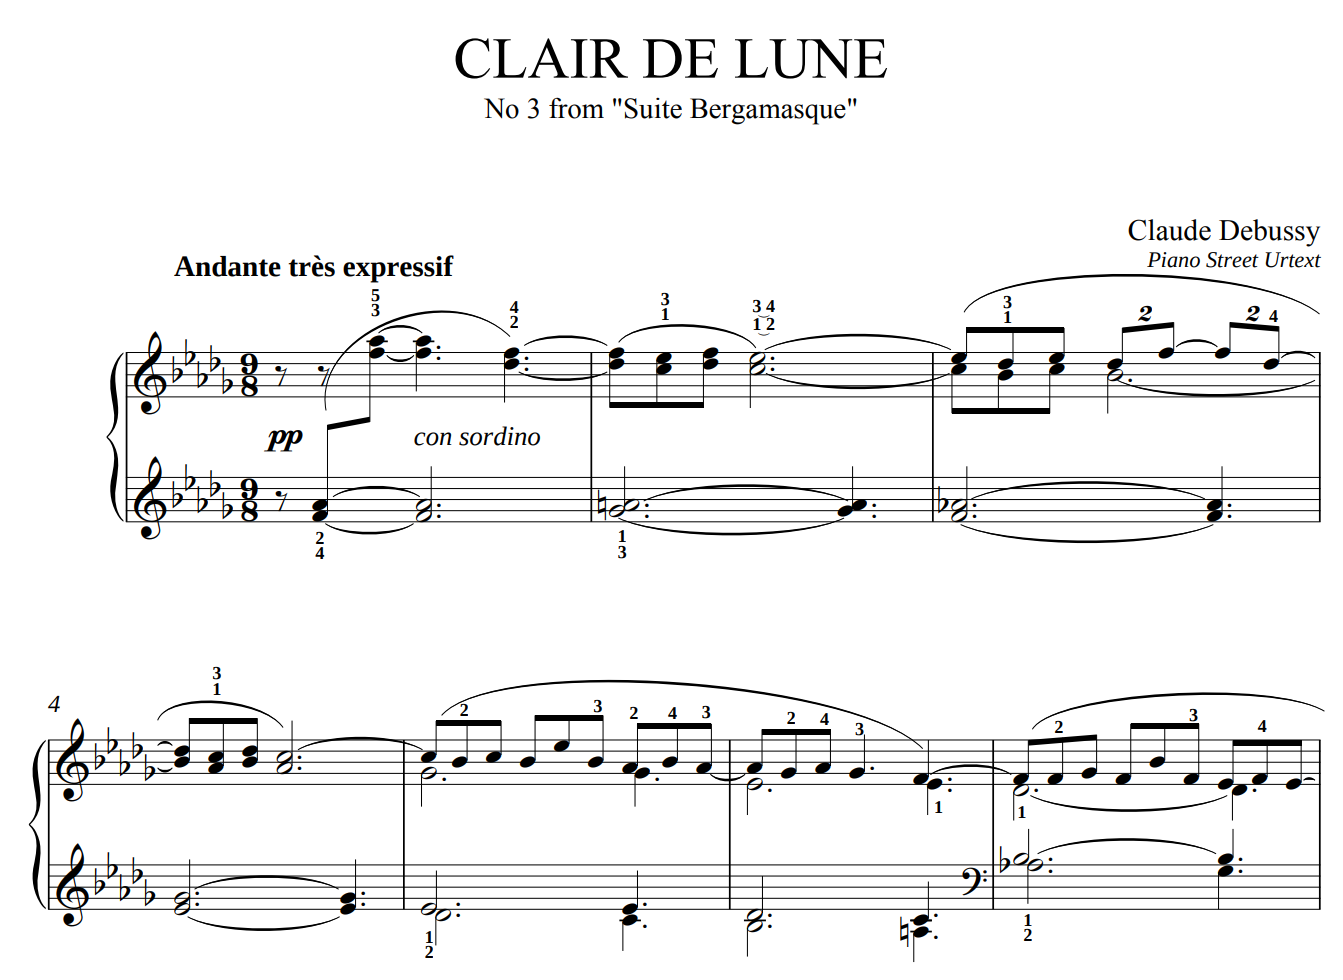

In [ ]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, range(1, 89), noty_v_case, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Noty')
plt.show()

# Bonusový materiál, aneb je škoda skončit zde, když je toho tolik zajímavého před námi

## Část 4: Využití derivace $f(x)$ pro rychlejší výpočet

Numerické metody pro minimalizaci funkcí mohou být výrazně efektivnější pokud je minimalizovaná funkce "hladká" a poskytneme algoritmu i informaci o derivaci funkce. 

V našem případě je funkce $f(x)$ diferencovatelná a její derivace (gradient) je: $$ \nabla_x f  = 2 A^T (A x - y_i) $$

In [ ]:
def df(x, A, y):
    r = A @ x - y
    return 2 * A.T @ r

Do funkce `minimize` můžeme předat gradient funkce pomocí parametru `jac`. 

In [ ]:
pocet_oken = casove_frekvencni_matice.shape[1]

noty_v_case = []

for i in range(pocet_oken):
    y_i = casove_frekvencni_matice[:, i]

    res = minimize(fun=f, x0=x0, args=(A, y_i), bounds=bounds, jac=df)
    noty_v_case.append(res.x)

noty_v_case = np.vstack(noty_v_case).T

**Tímto jsme výpočet cca 10x zrychlili.**

In [ ]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, range(1, 89), noty_v_case, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Noty')
plt.show()

## Část 5: Vyčistění řešení / penalizace přítomnosti více not
- výsledné řešení obsahuje hodně not, které mají pouze malou "váhu" a v nahrávce s největší pravděpodobností nejsou zahrány
- můžeme použít tzv. "penalizaci" pro počet not v řešení
    - na toto se nám bude hodit funkce (ideálně hladká), která od 0 bude velmi rychle stoupat k 1 a tu nepřesáhne
    - například funkce hyperbolického tangens: $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

In [ ]:
x = np.linspace(0, 3, 100)
y = np.tanh(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('tanh')
plt.grid(True)
plt.show()

Pokud chceme stoupání k 1 urychlit, stačí přenásobit $x$ v argumentu funkce $\tanh$ nějakým koeficientem $k$.

In [ ]:
x = np.linspace(0, 3, 100)
y = np.tanh(10 * x)

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('tanh')
plt.grid(True)
plt.show()

Minimalizace se změnila do následující podoby:
$$ x_i^* = \argmin_{x \in \mathbb{R}^{88},~~x_i \geq 0} ~~~\sum_{j}\left[ A x - y_i\right]_j^2 + \rho \sum_{l=1}^{88} \tanh (10[x]_l)$$

parametr $\rho$ určuje jak moc chceme penalizovat přítomnost více not v řešení. Budeme jej volit experimentálně.

In [ ]:
def f_penalta(x, A, y, rho):
    r = A @ x - y
    f_msq = np.sum(r**2)
    penalta = rho * np.sum(np.tanh(10*x))
    return f_msq + penalta

Ještě si přihodíme derivaci (gradient) penalizační funkce, ať to máme rychlejší.
$$ \frac {\partial \left(  \rho \sum_{l=1}^{88} \tanh (10[x]_l) \right)}{\partial x_l}  = 10 \rho (1 - \tanh ^2 (10x_l))$$

A tedy gradient jednoduše sestavíme po jednotlivých složkách.

In [ ]:
def df_penalta(x, A, y, rho):
    r = A @ x - y
    grad_msq = 2 * A.T @ r
    grad_penalta = rho * 10 * (1 - np.tanh(10 * x)**2)
    return grad_msq + grad_penalta

**K řešení:**
- kvůli penalizaci se komplexita řešení zvýšila, hlavně již bude velmi záležet na počátečním nátřelu `x0`, my máme k dispozici řešení bez penalizace, to použijeme jako počáteční nátřel
- jako hodnotu penalty zde zvolíme $\rho = 0.01$, kdybychom chtěli robustní metodu, mohli bychom vzít například $\rho = 0.1 f(x)$ pro předchozí řešení bez penalizace

In [ ]:
pocet_oken = casove_frekvencni_matice.shape[1]

noty_v_case_penalta = []

for i in range(pocet_oken):
    y_i = casove_frekvencni_matice[:, i]
    x0 = noty_v_case[:, i]
    res = minimize(fun=f_penalta, x0=x0, args=(A, y_i, 0.01), bounds=bounds, jac=df_penalta)
    noty_v_case_penalta.append(res.x)

noty_v_case_penalta = np.vstack(noty_v_case_penalta).T

In [ ]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, range(1, 89), noty_v_case_penalta, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Noty')
plt.show()

**Sice jsme se zbavili veškerého šumu, ale zase jsme ztratili  většinu údajů o délce zahraných not.**

## Část 6: Když nota hrála před chvílí, tak asi bude hrát i teď

- budeme využívat informaci o tom, které noty byly zahrány v předchozím časovém okně
- penalizovat budeme pouze noty, které se v předchozím okně nevyskytovaly

In [ ]:
def f_penalta2(x, A, y, rho, neznejici_noty):
    r = A @ x - y
    f_msq = np.sum(r**2)
    penalta = rho * np.sum(np.tanh(10 * x[neznejici_noty]))
    return f_msq + penalta


def df_penalta2(x, A, y, rho, neznejici_noty):
    r = A @ x - y
    grad_msq = 2 * A.T @ r
    grad_penalta = rho * 10 * (1 - np.tanh(10 * x)**2)
    grad_penalta[~neznejici_noty] = 0
    return grad_msq + grad_penalta

Pole booleanů `neznejici_noty` bude obsahovat informaci o tom, které noty nebyly zahrány v předchozím okně. Tedy, pokud je na pozici $i$ hodnota `True`, tak nota $i$ nebyla zahrána v předchozím okně.

- začneme se samými `True`, tedy všechny noty budou penalizovány
- po výpočtu v každém okně aktualizujeme hodnoty v poli `neznejici_noty` podle řešení v daném okně (hodnota řešení je menší než 0.01, tak nota nebyla zahrána)

In [ ]:
pocet_oken = casove_frekvencni_matice.shape[1]

noty_v_case_penalta2 = []
neznejici_noty = np.ones(88, dtype=bool)

for i in range(pocet_oken):
    y_i = casove_frekvencni_matice[:, i]
    x0 = noty_v_case[:, i]
    res = minimize(fun=f_penalta2, x0=x0, args=(A, y_i, 0.01, neznejici_noty), bounds=bounds, jac=df_penalta2)
    neznejici_noty = res.x < 0.01
    noty_v_case_penalta2.append(res.x)

noty_v_case_penalta2 = np.vstack(noty_v_case_penalta2).T

In [ ]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, range(1, 89), noty_v_case_penalta2, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Noty')
plt.show()

**Tak a to je vše, lepší identifikaci asi ani očekávat nemůžeme.**